In [ ]:
pwd

'/content'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!python --version

Python 3.11.12


In [3]:
import torch
torch.__version__

'2.6.0+cu124'

In [4]:
import torchvision

from torch import nn
from torchvision import transforms

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
!unzip /content/drive/MyDrive/AI_practice/ViT_ImageClassification/dataset.zip

Archive:  /content/drive/MyDrive/AI_practice/ViT_ImageClassification/dataset.zip
   creating: test/
   creating: test/daisy/
 extracting: test/daisy/476856232_7c35952f40_n_jpg.rf.28b0b70acae8079b2d47f23e5eefbd86.jpg  
 extracting: test/daisy/476857510_d2b30175de_n_jpg.rf.40ff83ae9c6f996b11149eaf1eafcc2e.jpg  
 extracting: test/daisy/488202750_c420cbce61_jpg.rf.ebf7d924209a96639fffea69bd279a8c.jpg  
   creating: test/dandelion/
 extracting: test/dandelion/129019877_8eea2978ca_m_jpg.rf.fefbc3553fc43efbc15140a65fff928c.jpg  
 extracting: test/dandelion/141340262_ca2e576490_jpg.rf.a9e7a7e679798619924bbc5cade9f806.jpg  
 extracting: test/dandelion/16159487_3a6615a565_n_jpg.rf.6d473a1fe680a3e930f3ff28464c46a9.jpg  
   creating: train/
   creating: train/daisy/
 extracting: train/daisy/11642632_1e7627a2cc_jpg.rf.8794534201606e49eee701066c2c5c82.jpg  
 extracting: train/daisy/21652746_cc379e0eea_m_jpg.rf.201c37ebf5b37bb72bf30f09064d927e.jpg  
 extracting: train/daisy/43474673_7bb4465a86_jpg.rf

In [7]:
#Directory path
train_dir = '/content/drive/MyDrive/AI_practice/ViT_ImageClassification/dataset/train'
test_dir = '/content/drive/MyDrive/AI_practice/ViT_ImageClassification/dataset/test'

In [8]:
#  Create Datasets and DataLoaders

import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [9]:
# Create image size
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [10]:
# Set the batch size
BATCH_SIZE = 32

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7a57cefc4250>,
 ['daisy', 'dandelion'])

torch.Size([3, 224, 224]) tensor(1)


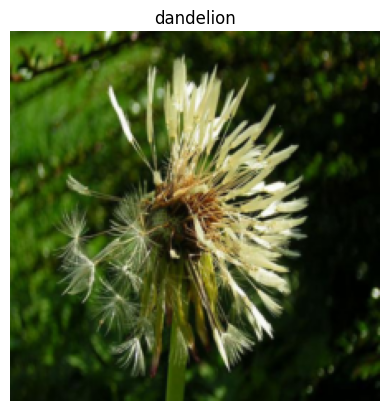

In [11]:
import matplotlib.pyplot as plt

# Let's visualize a image in order to know if data is loaded properly or not

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape, label)

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

In [12]:
import sys
sys.path.append('/content/drive/MyDrive/AI_practice')

from ViT_ImageClassification import vit_transformer_module
from ViT_ImageClassification.vit_transformer_module import PatchEmbedding
from ViT_ImageClassification.vit_transformer_module import MultiheadSelfAttentionBlock
from ViT_ImageClassification.vit_transformer_module import MLPBlock
from ViT_ImageClassification.vit_transformer_module import TransformerEncoderBlock
from ViT_ImageClassification.vit_transformer_module import ViT

In [14]:
# Train our MOdel
# Create an instance of ViT with the number of classes we're working with (daisy, dandelion)
vit = ViT(num_classes=len(class_names))



# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()


from ViT_ImageClassification import  engine
# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=100,
                       device=device)

# Save the trained model's state_dict
torch.save(vit.state_dict(), '/content/drive/MyDrive/AI_practice/ViT_ImageClassification/vit_trained_model.pth')


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8164 | train_acc: 0.5000 | test_loss: 9.6728 | test_acc: 0.5000
Epoch: 2 | train_loss: 9.5475 | train_acc: 0.5000 | test_loss: 3.7361 | test_acc: 0.5000
Epoch: 3 | train_loss: 3.7090 | train_acc: 0.5000 | test_loss: 4.5244 | test_acc: 0.5000
Epoch: 4 | train_loss: 4.4679 | train_acc: 0.5000 | test_loss: 2.6524 | test_acc: 0.5000
Epoch: 5 | train_loss: 2.6306 | train_acc: 0.5000 | test_loss: 0.7188 | test_acc: 0.5000
Epoch: 6 | train_loss: 0.7106 | train_acc: 0.5000 | test_loss: 1.5384 | test_acc: 0.5000
Epoch: 7 | train_loss: 1.5233 | train_acc: 0.5000 | test_loss: 0.7990 | test_acc: 0.5000
Epoch: 8 | train_loss: 0.7878 | train_acc: 0.5000 | test_loss: 1.3703 | test_acc: 0.5000
Epoch: 9 | train_loss: 1.3243 | train_acc: 0.5000 | test_loss: 0.8055 | test_acc: 0.5000
Epoch: 10 | train_loss: 0.7912 | train_acc: 0.5000 | test_loss: 0.9826 | test_acc: 0.5000
Epoch: 11 | train_loss: 0.9538 | train_acc: 0.5000 | test_loss: 0.8507 | test_acc: 0.5000
Epoch: 12 | train_l

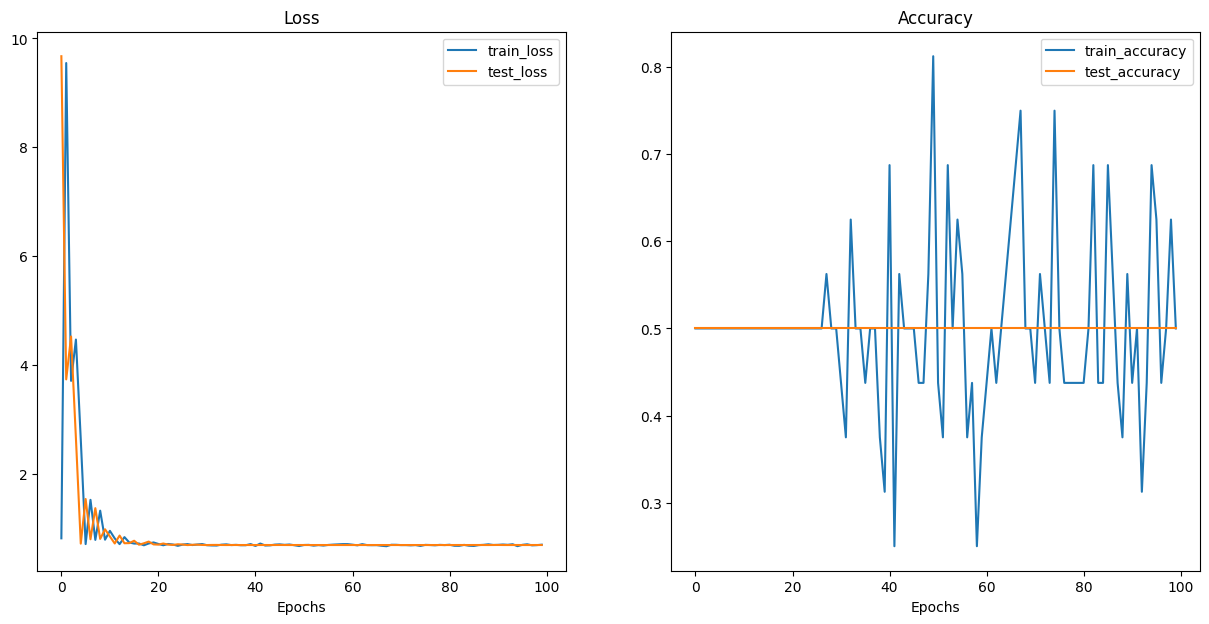

In [15]:
# To check out our ViT model's loss curves, we can use the plot_loss_curves function from helper_functions.py
from ViT_ImageClassification.helper_functions import plot_loss_curves


# Plot our ViT model's loss curves
plot_loss_curves(results)

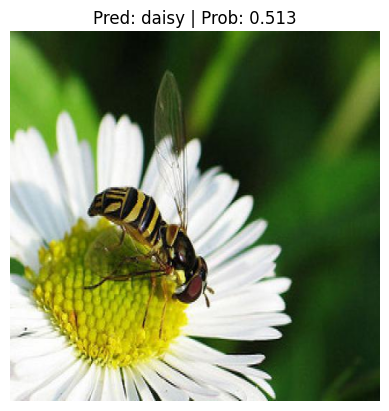

In [17]:
# Inference using trained model
import requests

# Import function to make predictions on images and plot them
from ViT_ImageClassification.helper_functions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/content/drive/MyDrive/AI_practice/ViT_ImageClassification/test.jpg"

# Predict on custom image
pred_and_plot_image(model=vit,
                    image_path=custom_image_path,
                    class_names=class_names)